In [1]:
#hide_input
#from wwf.utils import state_versions
#state_versions(['fastai', 'fastcore', 'wwf'])

In [2]:
# import all for vision
from fastai.data.all import *
#locals()


In [3]:
from fastai.vision.all import *
#print(locals())

# Checking the data

In [4]:
import os

# load data from notebook if exists
if os.path.exists ('./data'):
    data = Path('./data')
# or check HPC
elif os.path.exists('/scratch/users/anemet/stream1'):
    data = Path('/scratch/users/anemet/stream1')# or load data from google drive
else: 
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    data = Path('./drive/MyDrive/cvia')

In [5]:
#!cd

In [6]:
# checking files in the labels directory
data.ls()

(#7) [Path('/scratch/users/anemet/stream1/train.zip'),Path('/scratch/users/anemet/stream1/train'),Path('/scratch/users/anemet/stream1/labels.zip'),Path('/scratch/users/anemet/stream1/val.zip'),Path('/scratch/users/anemet/stream1/test'),Path('/scratch/users/anemet/stream1/test.zip'),Path('/scratch/users/anemet/stream1/labels')]

In [7]:
(data/'labels').ls()

(#3) [Path('/scratch/users/anemet/stream1/labels/sample_submission.csv'),Path('/scratch/users/anemet/stream1/labels/train.csv'),Path('/scratch/users/anemet/stream1/labels/val.csv')]

In [8]:
# loading train filenames + labels
dft = pd.read_csv(data/'labels/train.csv')
print(dft.shape) 
dft.head(2)

(66000, 3)


filename    class                  bbox
0  img086351.png  smart_1  [183, 311, 657, 415]
1  img083734.png  smart_1  [361, 352, 479, 716]

In [9]:
# loading validation filenames + labels
dfv = pd.read_csv(data/'labels/val.csv')
print(dfv.shape) 
dfv.head(2)

(22000, 3)


filename            class                  bbox
0  img055517.png  lisa_pathfinder  [375, 273, 610, 496]
1  img056814.png  lisa_pathfinder  [678, 302, 811, 448]

We have 66,000 training files and 22,000 validation files.

In [10]:
# train and validation files have been copied to the train directory #88,000 files in total:
(data/'train').ls()

(#88000) [Path('/scratch/users/anemet/stream1/train/img003838.jpg'),Path('/scratch/users/anemet/stream1/train/img062017.jpg'),Path('/scratch/users/anemet/stream1/train/img026677.jpg'),Path('/scratch/users/anemet/stream1/train/img047459.jpg'),Path('/scratch/users/anemet/stream1/train/img096466.jpg'),Path('/scratch/users/anemet/stream1/train/img083902.jpg'),Path('/scratch/users/anemet/stream1/train/img104096.jpg'),Path('/scratch/users/anemet/stream1/train/img012460.jpg'),Path('/scratch/users/anemet/stream1/train/img038571.jpg'),Path('/scratch/users/anemet/stream1/train/img037004.jpg')...]

We are going to manipulate the dataframe to reflect this and we are going to use our own train/validation split.

In [11]:
df = pd.concat([dft, dfv], axis=0, ignore_index=True)
print(df.shape) 
df.head(2)

(88000, 3)


filename    class                  bbox
0  img086351.png  smart_1  [183, 311, 657, 415]
1  img083734.png  smart_1  [361, 352, 479, 716]

In the dataframe the 'filename' column has .png extensions, but in reality we have .jpg files and we are going to replace the .png with .jpg

In [12]:
df['filename'] = df['filename'].str.replace('.png', '.jpg')

Checking the image properties:

In [13]:
images = [img for img in df['filename']]
images[:5]

['img086351.jpg',
 'img083734.jpg',
 'img081317.jpg',
 'img089140.jpg',
 'img082379.jpg']

In [14]:
img0 = images[0]

from PIL import Image

# Open an image file
with Image.open(data/'train'/img0) as img:
    # Get image dimensions
    width, height = img.size
    print(f"Resolution: {width} x {height}")


Resolution: 1024 x 1024


In [15]:
# getting bounding box values
bboxes = [eval(bb) for bb in df['bbox']]
bboxes[:2]

[[183, 311, 657, 415], [361, 352, 479, 716]]

In [16]:
# putting values in np.array
bboxes = np.array(bboxes)

In [17]:
# checking min and max values
bboxes.min(), bboxes.max()

(0, 1024)

We are going to resize the images to the ResNet image dimensions (224 x 224)

In [18]:
bbox224 = bboxes * 224 // 1024
bbox224[:2]

array([[ 40,  68, 143,  90],
       [ 78,  77, 104, 156]])

In [19]:
# checking min and max values:
bbox224.min(), bbox224.max()

(0, 224)

Limiting bboxes values to the range 0..223

In [20]:
bbox224 = np.clip(bbox224, 0, 223)
bbox224.min(), bbox224.max()

(0, 223)

In [21]:
classes = [c for c in df['class']]
classes[:3]

['smart_1', 'smart_1', 'smart_1']

In [22]:
bbox224_label = list(zip(bbox224, classes))
bbox224_label[:2]

[(array([ 40,  68, 143,  90]), 'smart_1'),
 (array([ 78,  77, 104, 156]), 'smart_1')]

In [23]:
img2bbox224 = dict(zip(images, bbox224_label))

# example of the label for img0
img2bbox224[img0]

(array([ 40,  68, 143,  90]), 'smart_1')

In [24]:
# look at a sample from our dictionary
k = L(img2bbox224)[1]; k,img2bbox224[k]

('img083734.jpg', (array([ 78,  77, 104, 156]), 'smart_1'))

# Visualize bbox

We are going to define helper functions to draw boxes over images:

In [25]:
import matplotlib.colors as mcolors
import matplotlib.cm as cmx
from matplotlib import patches, patheffects

SIZE=224

# display an image in such a way that we can layer on some additional annotations
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    show_image(im,ax) # We use this FastAI method to make life a little easier
    ax.set_xticks(np.linspace(0, SIZE, 8))
    ax.set_yticks(np.linspace(0, SIZE, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

# draw an outline around the shape; used to add contrast to the text so we can read it easily
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

# draw text in the specified location along with an outline so that there is some contrast between the text and the image
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

# generate a list of different colors for rendering our bounding boxes
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]


In [26]:
# Draw image with bounding box only
def show_item(im, lbl_bbox, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax = show_img(im, ax=ax)
    b = lbl_bbox[0]
    l = lbl_bbox[1]
    b = (*b[:2],b[2]-b[0]+1,b[3]-b[1]+1)
    draw_rect(ax, b, color=colr_list[0])
    draw_text(ax, b[:2], l, color=colr_list[0])

Viewing a few samples:

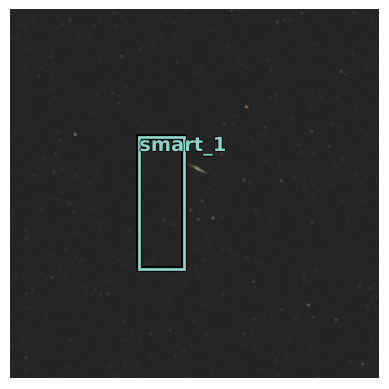

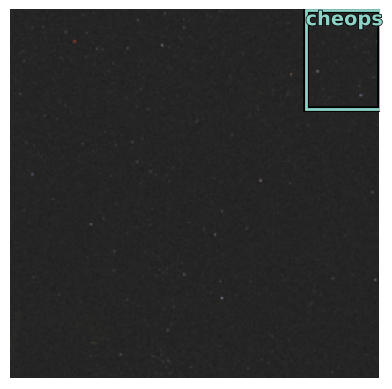

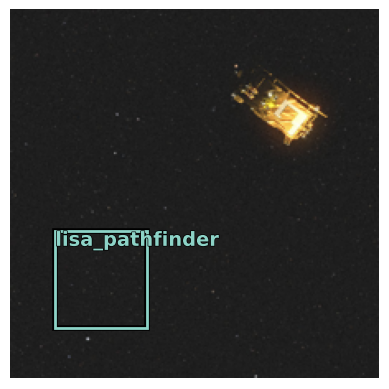

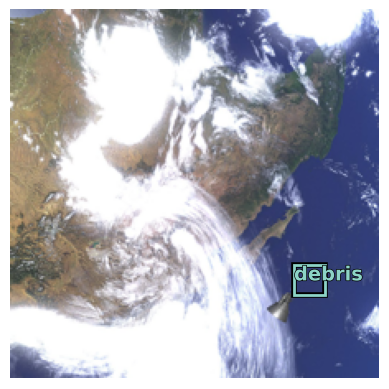

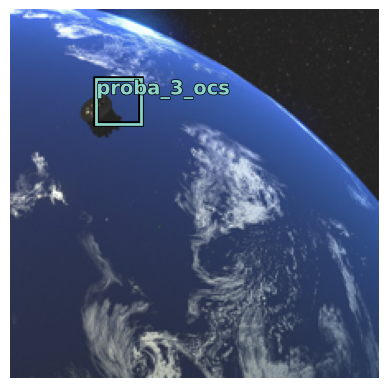

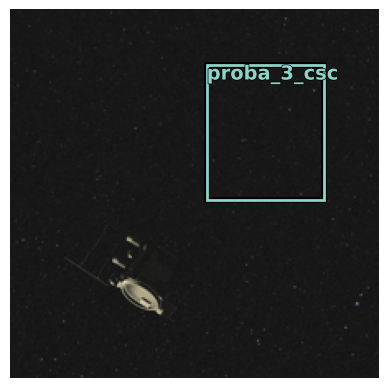

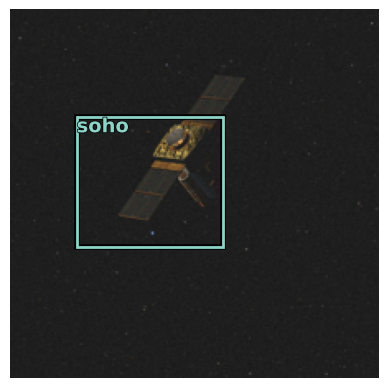

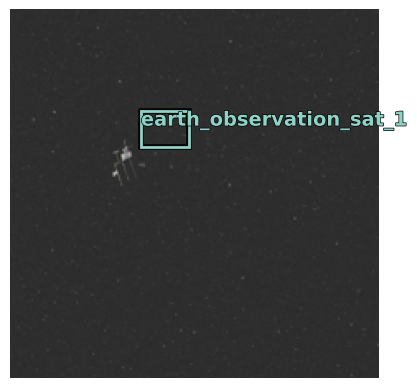

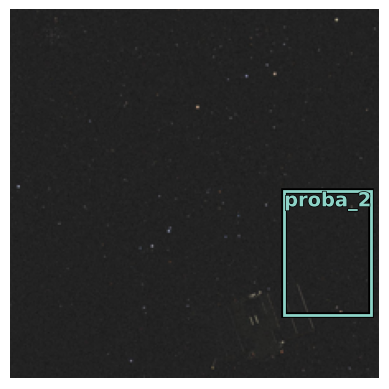

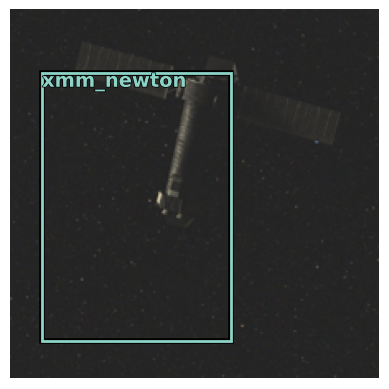

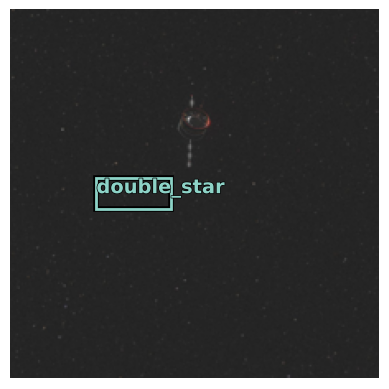

In [27]:
for i in range(1, 66000, 6000):
    img = images[i]                     # 'img086351.jpg'
    img_bbox_label = img2bbox224[img]     # (array([ 40,  68, 143,  90]), 'smart_1')

    img_scaled = Image.open(data/'train'/img).resize((SIZE, SIZE))

    show_item(img_scaled, img_bbox_label)

These images suggest that x and y coordinates are swapped to our expectations, so we are going to swap and regenerate our labels.

## Swapping x,y in bbox coordinates

In [28]:
# checking first items
bbox224[:2]

array([[ 40,  68, 143,  90],
       [ 78,  77, 104, 156]])

In [29]:
# swapping x <-> y coordinates and checking result
bbox224[:, [0, 1, 2, 3]] = bbox224[:, [1, 0, 3, 2]]
bbox224[:2]

array([[ 68,  40,  90, 143],
       [ 77,  78, 156, 104]])

In [30]:
# regenerating bbox224_label
bbox224_label = list(zip(bbox224, classes))
bbox224_label[:2]

[(array([ 68,  40,  90, 143]), 'smart_1'),
 (array([ 77,  78, 156, 104]), 'smart_1')]

In [31]:
# regenerating img2bbox224
img2bbox224 = dict(zip(images, bbox224_label))

# example of the label for img0
img2bbox224[img0]

(array([ 68,  40,  90, 143]), 'smart_1')

In [32]:
# look at a sample from our dictionary
k = L(img2bbox224)[1]; k,img2bbox224[k]
# ('000017.jpg', [(41.0, 47.0, 188.0, 206.0), 'horse'])

('img083734.jpg', (array([ 77,  78, 156, 104]), 'smart_1'))

Let's try once more viewing a few samples from our training set:

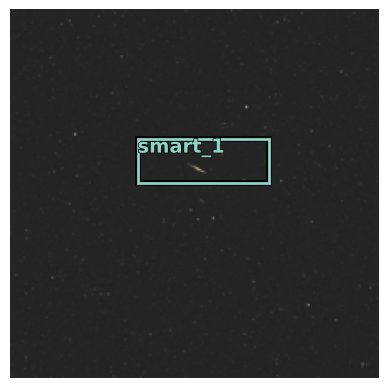

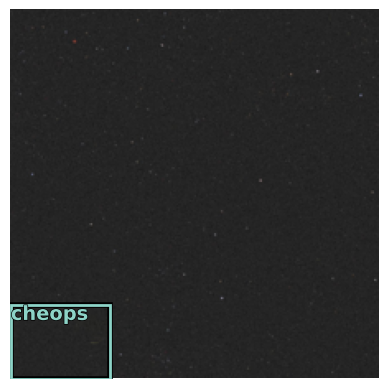

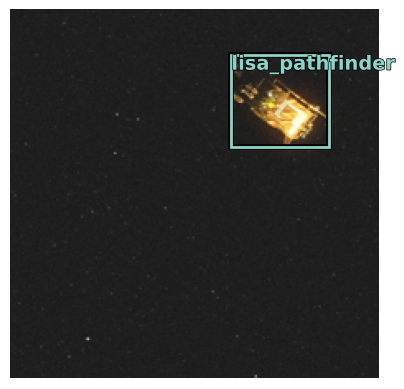

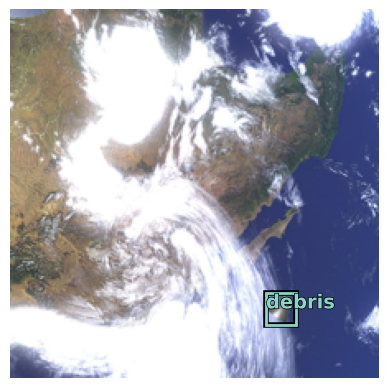

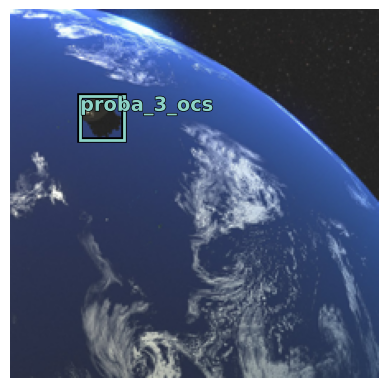

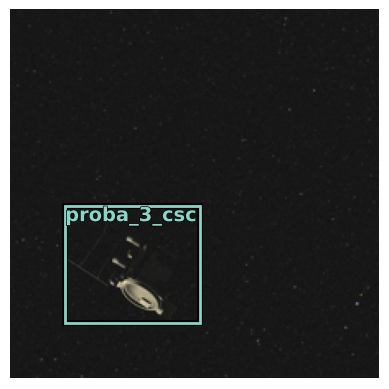

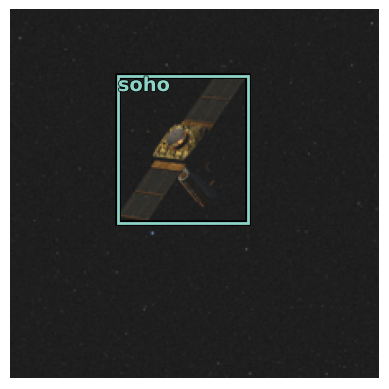

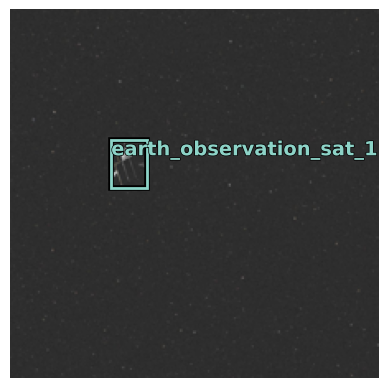

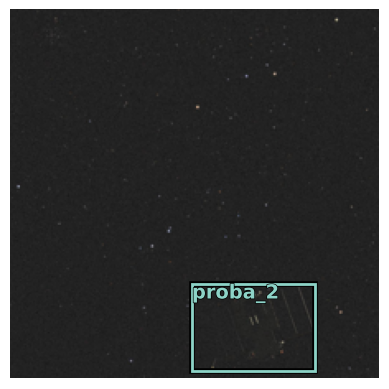

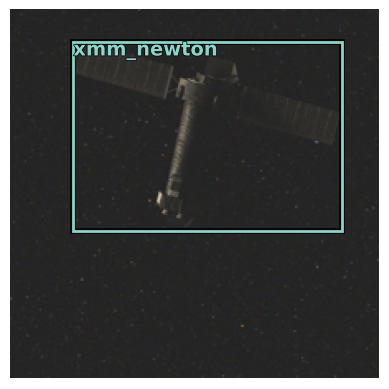

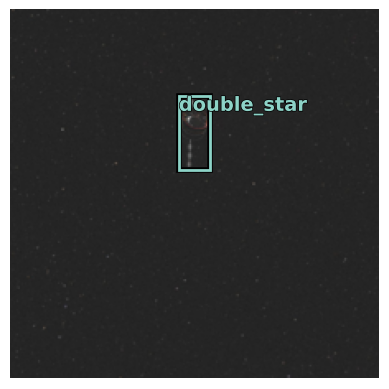

In [33]:
for i in range(1, 66000, 6000):
    img = images[i]                     # 'img086351.jpg'
    img_bbox_label = img2bbox224[img]     # (array([ 40,  68, 143,  90]), 'smart_1')

    img_scaled = Image.open(data/'train'/img).resize((SIZE, SIZE))

    show_item(img_scaled, img_bbox_label)

# Setting up the DataBlock / Dataloaders

We can load data into fastai through the [DataBlock API](https://docs.fast.ai/tutorial.datablock.html) - here we are going to specify the blueprint of our data, and we are going to load the data through the dataloaders method by specifying the source.

We are specifying first the getter functions:
1. the first getter is returning the full path to the image
2. the second getter returns a tensor containing the four bounding box coordinates of the image
3. the third getter returns a string specifying the class label of the object in image

In [34]:
getters = [lambda o: data/'train'/o, 
           lambda o: FloatTensor(img2bbox224[o][0]),
           lambda o: img2bbox224[o][1]]

In [35]:
# testing the getters:
img0, getters[0](img0), getters[1](img0), getters[2](img0)

('img086351.jpg',
 Path('/scratch/users/anemet/stream1/train/img086351.jpg'),
 tensor([ 68.,  40.,  90., 143.]),
 'smart_1')

We are going to use one ImageBlock for input, one RegressionBlock with 4 activations (to predict the coordinates of the bounding boxes) and a CategoryBLock (to predict the image class) for outputs.

In [36]:
# aug_transforms that don't require bbox manipulation
batch_tfms = [
              Brightness(max_lighting=0.2, p=0.22),
              Contrast(max_lighting=0.2, p=0.22),
#              RandomErasing(p=0.75, sh=0.1),     # same for an entire batch :-(
              Saturation(max_lighting=0.1, p=0.11),
#              Hue(max_hue=0.1, p=0.2),           # not good for dimension
              Normalize.from_stats(*imagenet_stats)
]

In [37]:
stream1 = DataBlock(blocks=(ImageBlock, RegressionBlock(n_out=4), CategoryBlock),
                   getters=getters,
                   item_tfms=Resize(224, method='squish'),
                   # batch_tfms=[Rotate(3), Flip(), Dihedral()]   # image augmentation
                   batch_tfms=batch_tfms,
                   n_inp=1                                        # 1 input, 2 outputs
                   )

We are going to skip the image augmentation in the beginning.

In [38]:
# loading the data
dls = stream1.dataloaders(images)

In [39]:
# checking the class labels
len(dls.vocab), dls.vocab

(11,
 ['cheops', 'debris', 'double_star', 'earth_observation_sat_1', 'lisa_pathfinder', 'proba_2', 'proba_3_csc', 'proba_3_ocs', 'smart_1', 'soho', 'xmm_newton'])

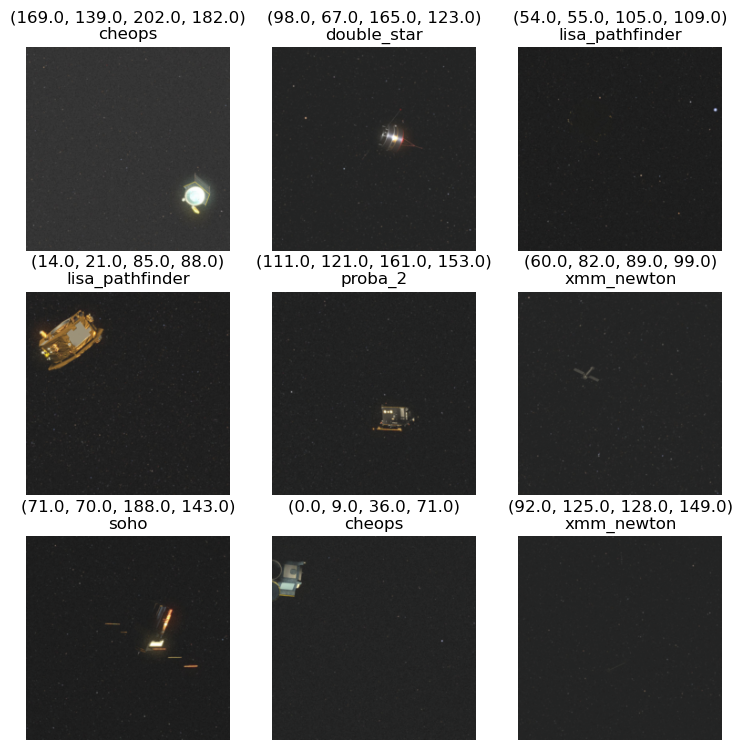

In [40]:
# checking the loaded images
dls.show_batch()

We can see the coordinates of the bounding boxes, but it would be better to see the boxes to make sure dataloading is ok:

In [41]:
def bb_hw(a): return np.array([a[0],a[1],a[2]-a[0]+1,a[3]-a[1]+1])

def show_batch(dls):
    b = dls.one_batch()
    #print(b[2])

    axs = subplots(3,3)[1].flat
    for img,box,c,ax in zip(b[0][:9],b[1][:9],b[2],axs):
        show_img(img,ax=ax)
        label = dls.vocab[c]
        draw_rect(ax,bb_hw(box.tolist()),color=colr_list[0])
        draw_text(ax,bb_hw(box.tolist())[:2],label,color=colr_list[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


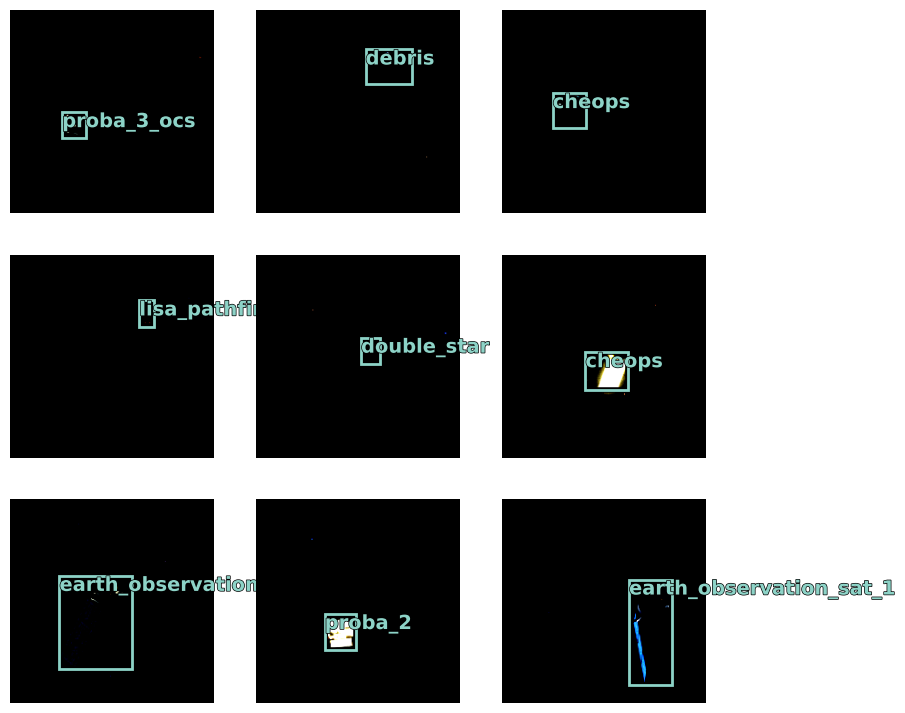

In [42]:
show_batch(dls)

# Setting up the model


We are going to use transfer learning from the resnet34.  

We will need to build our custom head which has an output of 4 activations for the bounding box coordinates + 1 activation for each class label (11 in our case)

In [43]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 4 + len(dls.vocab)),
)

Our loss function will treat the bounding box activations differently than the activations used for the class label prediction.  The bounding box prediction is a regression problem and we'll use the l1_loss.  For the class label we are going to use the cross_entropy loss.  Since the loss function can only return a single value, we have to combine these loss terms in a single value. 

The two different loss terms are on different scales and we are going to multiply the cross_entropy_loss term with CROSS_ENTROPY_SCALE - a hyperparameter trying to ensure that the two terms are equally weighted.

In [44]:
# IoU - Intersection over Union
# (Area of Intersection of predicted with target) / (Area of Union of predicted and target)

def detn_iou(input_, bb_t, c_t):
    bb_i = input_[:, :4]
    bb_i = F.sigmoid(bb_i) * 224 # scaling to the range 0..224
    
    # Determine the (x, y)-coordinates of the intersection rectangle
    xA = torch.max(bb_i[:, 0], bb_t[:, 0])
    yA = torch.max(bb_i[:, 1], bb_t[:, 1])
    xB = torch.min(bb_i[:, 2], bb_t[:, 2])
    yB = torch.min(bb_i[:, 3], bb_t[:, 3])

    # Compute the area of intersection rectangle
    interArea = torch.clamp(xB - xA, min=0) * torch.clamp(yB - yA, min=0)

    # Compute the area of both the prediction and ground-truth rectangles
    bb_iArea = (bb_i[:, 2] - bb_i[:, 0]) * (bb_i[:, 3] - bb_i[:, 1])
    bb_tArea = (bb_t[:, 2] - bb_t[:, 0]) * (bb_t[:, 3] - bb_t[:, 1])

    # Compute the area of union
    unionArea = bb_iArea + bb_tArea - interArea

    # Compute the IoU
    iou = interArea / unionArea

    return iou.mean()  # Return the average IoU for the batch

In [45]:
# hyperparameter
CROSS_ENTROPY_SCALE = 1
EPSILON = 0.1

def detn_loss(input_, bb_t, c_t):
    # separate the bbox prediction from class label prediction
    bb_i, c_i = input_[:, :4], input_[:, 4:]
    # squash the bbox activations to range (0..1) and scale up to range 0..224 (SIZE)
    bb_i = F.sigmoid(bb_i) * SIZE
    # combining the two losses
    l1_ce_loss = F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*CROSS_ENTROPY_SCALE
    # getting iou
    iou = detn_iou(input_, bb_t, c_t)   # [0..1], bigger -> better
    iou_loss = (1/(iou + EPSILON) - 1)  # [0..1/EPSILON] -> lower -> better
    # returning combined loss with iou
    # return l1_ce_loss * (1/(iou + EPSILON) - 1)
    # return F.cross_entropy(c_i, c_t) * (1/(iou + EPSILON) - 1)
    return l1_ce_loss + iou_loss

- input : activations.
- target : ground truth.
- bb_i, bb_t: bounding box input, bounding box target
- c_i, c_t: class input, class target
- bb_i, c_i = input_[:, :4], input_[:, 4:] : the first : is for the batch dimension. e.g.: 64 (for 64 images).

We are going to define a few custom metrics that we can print during trainig:

In [46]:
# The bounding box loss term (l1_loss)
def detn_l1(input_, bb_t, c_t):
    bb_i = input_[:, :4]
    bb_i = F.sigmoid(bb_i) * 224
    return F.l1_loss(bb_i, bb_t).data

# The class label loss term (cross entropy loss)
def detn_ce(input_, bb_t, c_t):
    c_i = input_[:, 4:]
    return F.cross_entropy(c_i, c_t.data)

# Accuracy of the class label prediction
def detn_acc(input_, bb_t, c_t):
    c_i = input_[:, 4:]
    return accuracy(c_i, c_t)

We are no going to create the fastai learner using the custom head, the compound loss function and the custom metrics:

In [47]:
learn = vision_learner(dls, resnet34,
                      loss_func=detn_loss,
                      custom_head=head_reg4,
                      metrics=[detn_l1, detn_iou, detn_ce, detn_acc])

Let's take a look at the custom head added to the model:

In [48]:
head = learn.model[1]
head

Sequential(
  (0): fastai.layers.Flatten(full=False)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=25088, out_features=256, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=15, bias=True)
)

We can see that the out_features=15 - this corresponds to the 4 bbox values + 11 classes.

We can have a look at the resnet34 body as well:

In [49]:
body = learn.model[0]
body

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

Here is an overview of the whole model:

In [50]:
#learn.summary()

In [51]:
#learn.unfreeze()
#learn.freeze_to(2)
#learn.summary()

In [52]:
def check_layers(learner):
    for i, (name, param) in enumerate(learner.model.named_parameters()):
        print(f"{name} is {'unfrozen' if param.requires_grad else 'frozen'}")

#check_layers(learn)

# Train the model

Let's start with finding a reasonable learning rate:

/home/users/anemet/miniconda3/envs/fai/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392026823/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


SuggestedLRs(valley=0.0008317637839354575)

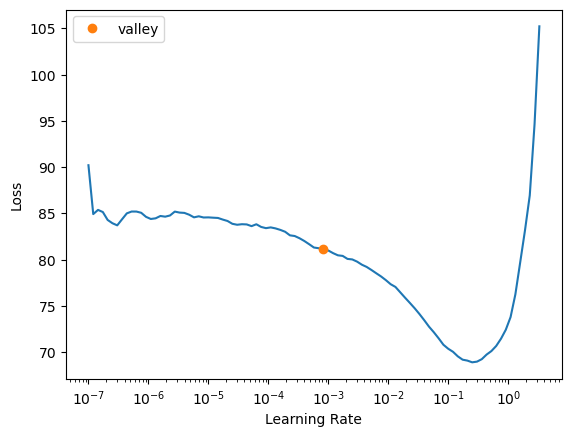

In [53]:
lrs = learn.lr_find()
lrs

In [54]:
lrs

SuggestedLRs(valley=0.0008317637839354575)

Training the model with the suggested learning rate:


In [55]:
learn.fine_tune(4, base_lr=lrs.valley)
#learn.fine_tune(2, base_lr=0.002)

In [56]:
lrs = learn.lr_find()
lrs

In [57]:
# hyperparameter
CE_SCALE = 1
EPSILON = 0.05
IOU_SCALE = 20

def detn_loss(input_, bb_t, c_t):
    # separate the bbox prediction from class label prediction
    bb_i, c_i = input_[:, :4], input_[:, 4:]
    # squash the bbox activations to range (0..1) and scale up to range 0..224 (SIZE)
    bb_i = F.sigmoid(bb_i) * SIZE
    # combining the two losses
    l1_ce_loss = F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t) * CE_SCALE
    # getting iou
    iou = detn_iou(input_, bb_t, c_t)   # [0..1], bigger -> better
    iou_loss = (1/(iou + EPSILON) - 1)  # [0..1/EPSILON] -> lower -> better
    # returning combined loss with iou
    # return l1_ce_loss * (1/(iou + EPSILON) - 1)
    # return F.cross_entropy(c_i, c_t) * (1/(iou + EPSILON) - 1)
    return l1_ce_loss + IOU_SCALE * iou_loss

SuggestedLRs(valley=1.0964781722577754e-06)

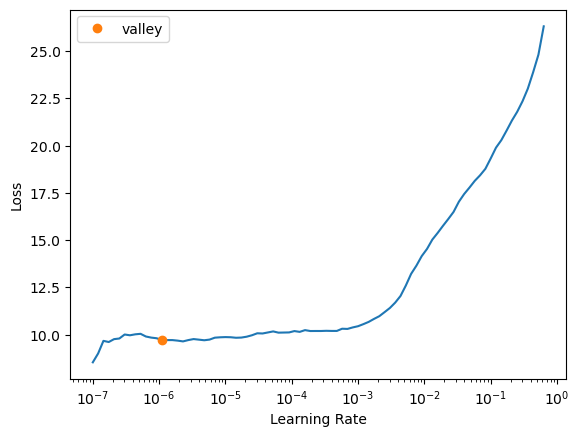

In [58]:
lrs = learn.lr_find()
lrs

In [59]:
learn.freeze()
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

SuggestedLRs(valley=0.0003311311302240938)

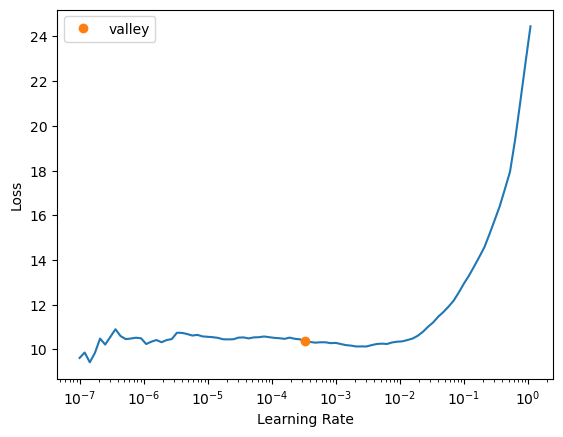

In [60]:
lrs = learn.lr_find()
lrs

In [69]:
# aug_transforms that don't require bbox manipulation
batch_tfms = [
              Brightness(max_lighting=0.2, p=0.55),
              Contrast(max_lighting=0.2, p=0.55),
#              RandomErasing(p=0.75, sh=0.1),     # same for an entire batch :-(
              Saturation(max_lighting=0.1, p=0.33),
#              Hue(max_hue=0.1, p=0.2),           # not good for dimension
              Normalize.from_stats(*imagenet_stats)
]

In [70]:
stream1 = DataBlock(blocks=(ImageBlock, RegressionBlock(n_out=4), CategoryBlock),
                   getters=getters,
                   item_tfms=Resize(224, method='squish'),
                   # batch_tfms=[Rotate(3), Flip(), Dihedral()]   # image augmentation
                   batch_tfms=batch_tfms,
                   n_inp=1                                        # 1 input, 2 outputs
                   )

In [71]:
# loading the data
dls = stream1.dataloaders(images)

SuggestedLRs(valley=0.0005754399462603033)

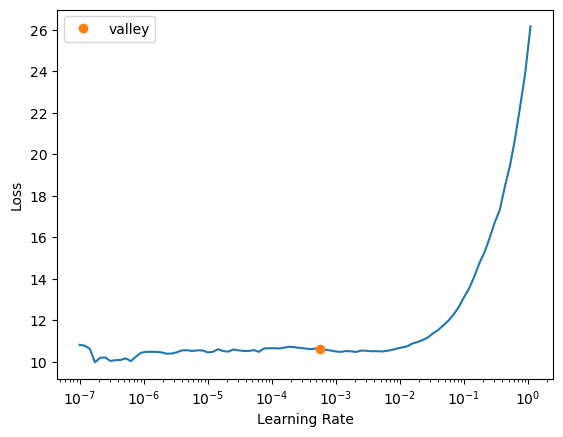

In [72]:
lrs = learn.lr_find()
lrs

In [73]:
# hyperparameter
CE_SCALE = 1
EPSILON = 0.02
IOU_SCALE = 50

def detn_loss(input_, bb_t, c_t):
    # separate the bbox prediction from class label prediction
    bb_i, c_i = input_[:, :4], input_[:, 4:]
    # squash the bbox activations to range (0..1) and scale up to range 0..224 (SIZE)
    bb_i = F.sigmoid(bb_i) * SIZE
    # combining the two losses
    l1_ce_loss = F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t) * CE_SCALE
    # getting iou
    iou = detn_iou(input_, bb_t, c_t)   # [0..1], bigger -> better
    iou_loss = (1/(iou + EPSILON) - 1)  # [0..1/EPSILON] -> lower -> better
    # returning combined loss with iou
    # return l1_ce_loss * (1/(iou + EPSILON) - 1)
    # return F.cross_entropy(c_i, c_t) * (1/(iou + EPSILON) - 1)
    return l1_ce_loss + IOU_SCALE * iou_loss

SuggestedLRs(valley=9.120108734350652e-05)

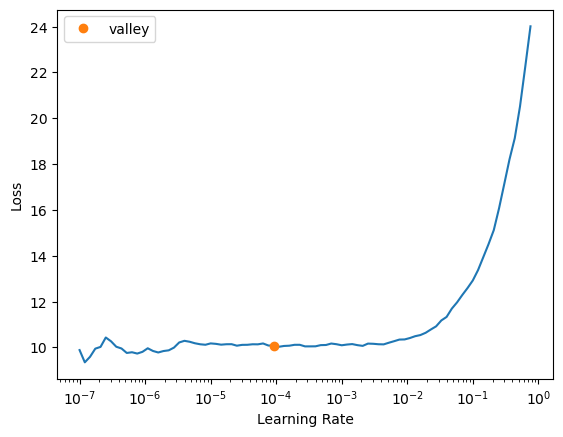

In [74]:
lrs = learn.lr_find()
lrs

In [75]:
# hyperparameter
CE_SCALE = 1
EPSILON = 0.05
IOU_SCALE = 20

def detn_loss(input_, bb_t, c_t):
    # separate the bbox prediction from class label prediction
    bb_i, c_i = input_[:, :4], input_[:, 4:]
    # squash the bbox activations to range (0..1) and scale up to range 0..224 (SIZE)
    bb_i = F.sigmoid(bb_i) * SIZE
    # combining the two losses
    l1_ce_loss = F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t) * CE_SCALE
    # getting iou
    iou = detn_iou(input_, bb_t, c_t)   # [0..1], bigger -> better
    iou_loss = (1/(iou + EPSILON) - 1)  # [0..1/EPSILON] -> lower -> better
    # returning combined loss with iou
    # return l1_ce_loss * (1/(iou + EPSILON) - 1)
    # return F.cross_entropy(c_i, c_t) * (1/(iou + EPSILON) - 1)
    return l1_ce_loss + IOU_SCALE * iou_loss

SuggestedLRs(valley=0.0002754228771664202)

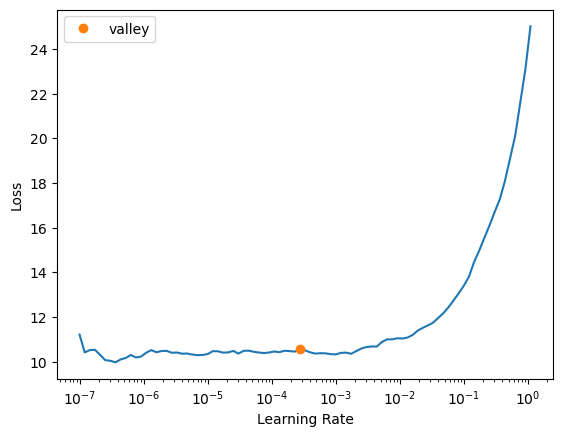

In [79]:
lrs = learn.lr_find()
lrs

In [80]:
learn.fine_tune(3, base_lr=lrs.valley)
#learn.fine_tune(2, base_lr=0.002)

# Making predictions

In [81]:
# Some functions to visulize the predictions of our model.
def bb_hw(a): return np.array([a[0],a[1],a[2]-a[0]+1,a[3]-a[1]+1])

def show_preds(learner,valid=True):
    dl = learn.dls[1 if valid else 0].new(shuffle=True)
    imgs,boxes,labels = dl.one_batch()
    learner.model.eval()
    preds = learner.model(imgs)

    fig,axs = subplots(9,2)
    for img,box,label,pred,ax in zip(imgs,boxes,labels,preds,axs):
        img = (img-img.min())/(img.max()-img.min())
        bb_pred = F.sigmoid(pred[:4])*224
        cl_pred = pred[4:]
        cl_pred = cl_pred.argmax()
        show_img(img,ax=ax[0])
        draw_rect(ax[0],bb_hw(box.tolist()),color=colr_list[0])
        draw_text(ax[0],bb_hw(box.tolist())[:2],learner.dls.vocab[label],color=colr_list[0])
        show_img(img,ax=ax[1])
        draw_rect(ax[1],bb_hw(bb_pred.tolist()),color=colr_list[0])
        draw_text(ax[1],bb_hw(bb_pred.tolist())[:2],learner.dls.vocab[cl_pred],color=colr_list[0])
    fig.tight_layout()
    axs[0][0].set_title('label')
    axs[0][1].set_title('prediction')
    plt.show()

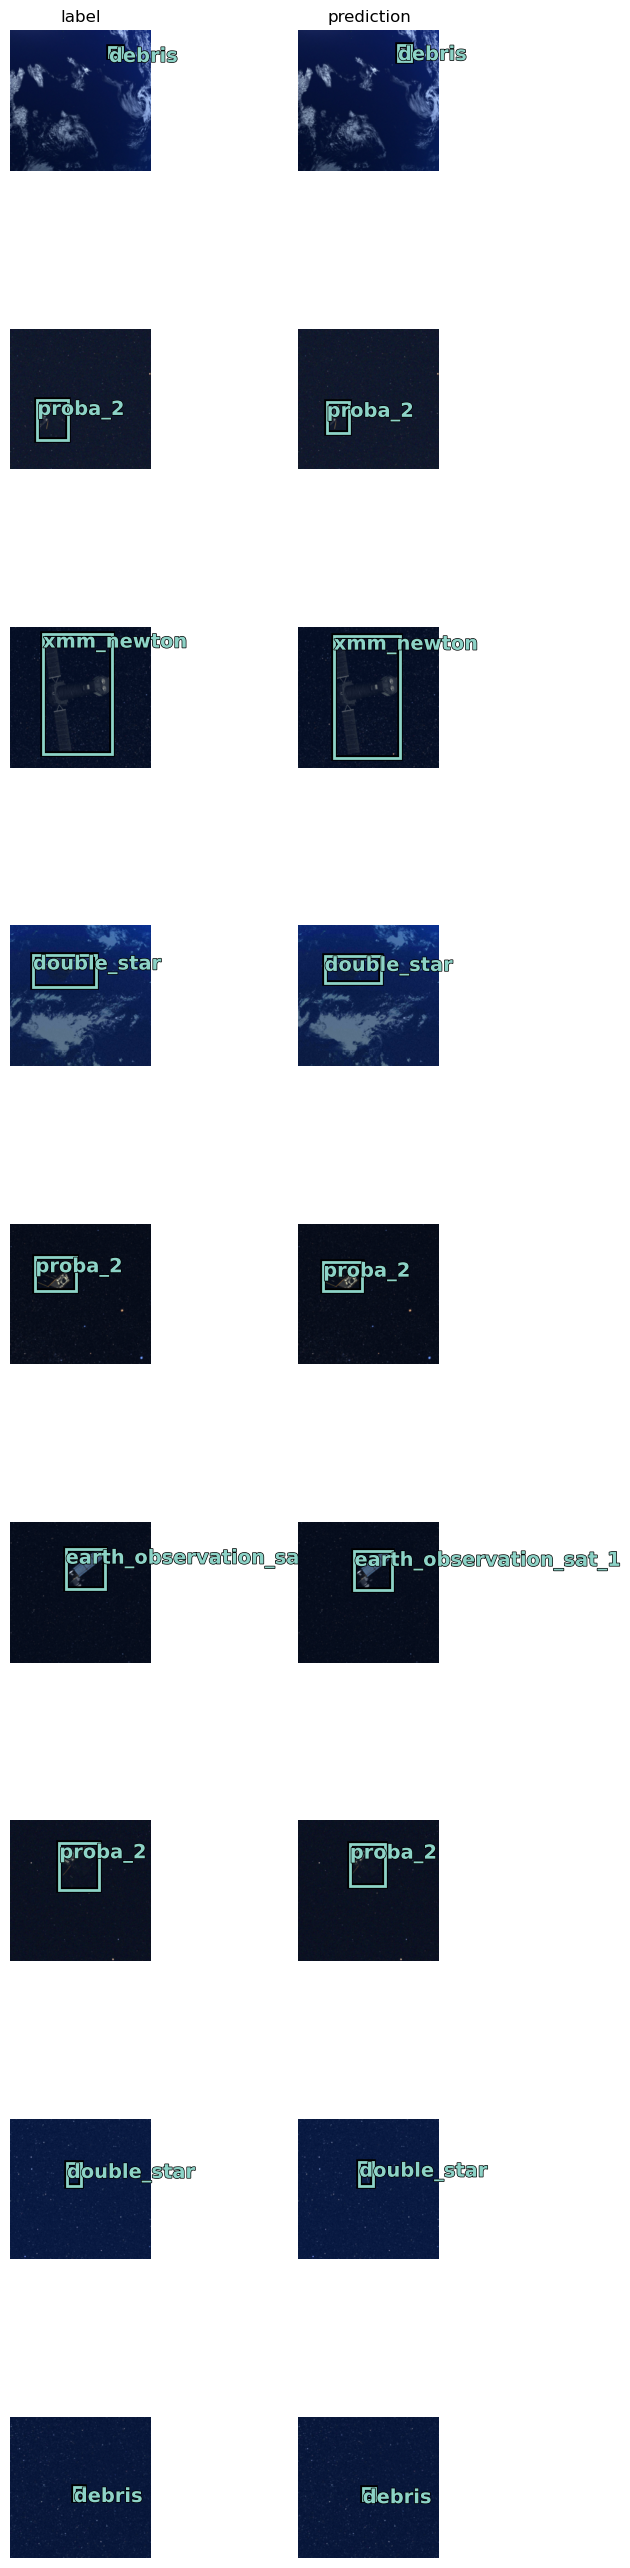

In [82]:
show_preds(learn)

## Saving weights

In [83]:
# preparing filename for weights
from datetime import datetime
now = datetime.now()
fname = f'weights_{now.year}-{now.month:02}-{now.day:02}_{now.hour:02}-{now.minute:02}'
fname

'weights_2023-11-14_16-13'

In [84]:
# saving model weights
learn.save(fname)

Path('models/weights_2023-11-14_16-13.pth')

# Predicting labels on the test set

In [85]:
# testimages = dftest['filename']
# len(testimages)

In [86]:
# loading test images 
test_dl = learn.dls.test_dl(get_image_files(data/'test'))

In [87]:
# getting predictions
preds, _ = learn.get_preds(dl=test_dl)

In [88]:
# extracting bbox and class from predictions
bb_pred = preds[:, :4]
bb_pred.min(), bb_pred.max()

(tensor(-16.1298), tensor(229.5082))

In [89]:
cl_pred = preds[:, 4:]
cl_pred.min(), cl_pred.max()

(tensor(-700.2369), tensor(276.0457))

In [90]:
# extracting bbox and class from predictions
bb_pred = np.intc(F.sigmoid(preds[:, :4])*224)
cl_pred = preds[:, 4:]
cl_pred = cl_pred.argmax(dim=1)
# getting class names
class_pred = [learn.dls.vocab[c] for c in cl_pred]

In [91]:
# bbox predictions for viewing
bb_pred.min(), bb_pred.max()

(0, 224)

In [92]:
# bbox predictions for submit
bb_pred_1024 = np.intc(F.sigmoid(preds[:, :4])*1024)
# bbox predictions for submit with x,y swapped
# swapping x <-> y coordinates and checking result
bb_pred_1024[:, [0, 1, 2, 3]] = bb_pred_1024[:, [1, 0, 3, 2]]
bb_pred_1024[:2]

array([[ 265,  822,  337,  919],
       [  88,  434,  779, 1012]], dtype=int32)

In [93]:
bbox_lbl_pred = list(zip(bb_pred, class_pred))

In [94]:
# recovering the test image filenames
items = test_dl.items    # path
predimages = [i.name for i in items]

In [95]:
# preparing the img2bbox_pred
img2bbox_pred = dict(zip(predimages, bbox_lbl_pred))
img0 = predimages[0]
# example of the label for img0
img0, img2bbox_pred[img0]

('img028488.jpg', (array([180,  58, 201,  73], dtype=int32), 'debris'))

/tmp/ipykernel_1646107/3664820570.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  if not ax: fig,ax = plt.subplots(figsize=figsize)


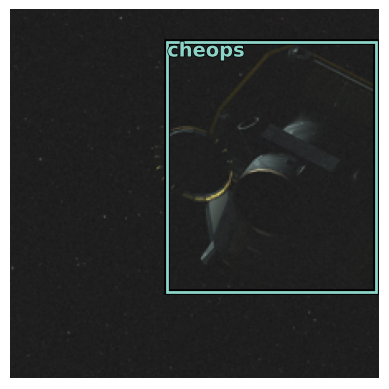

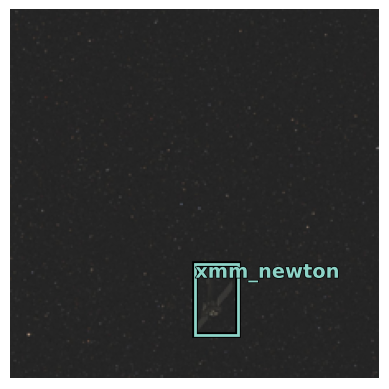

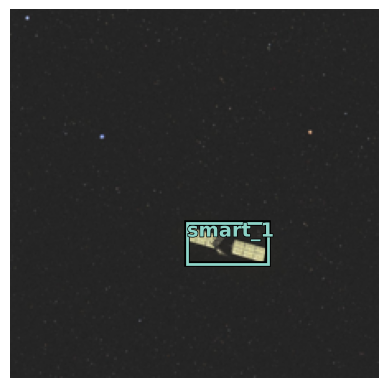

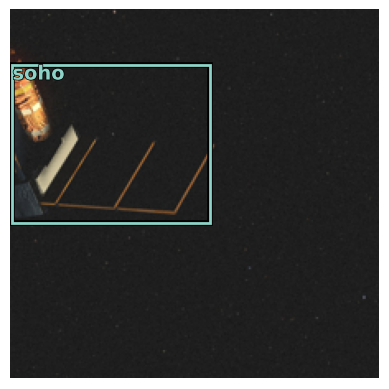

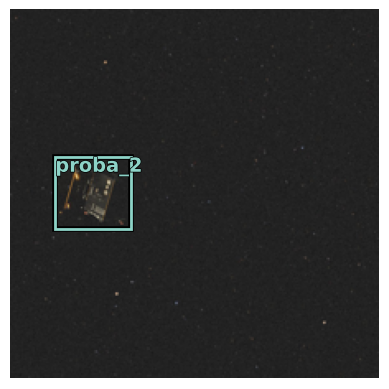

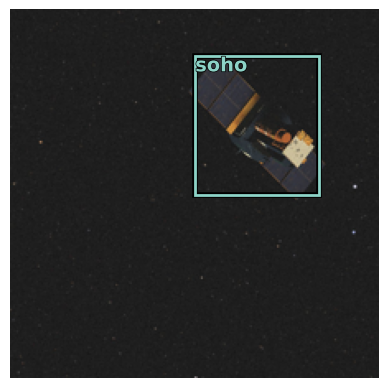

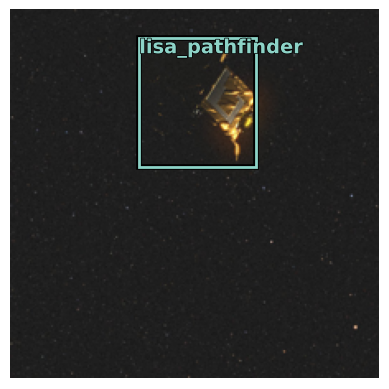

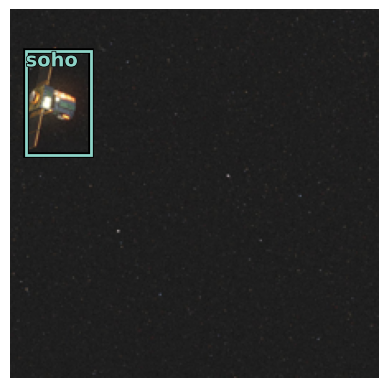

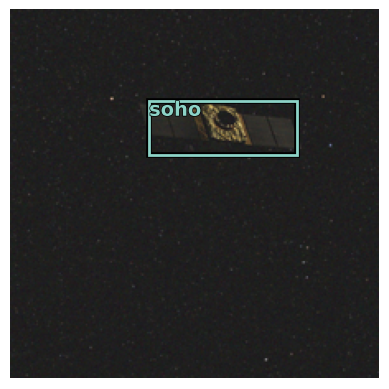

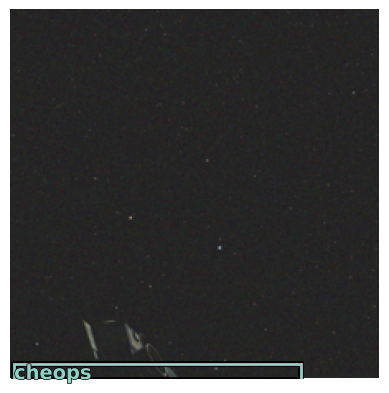

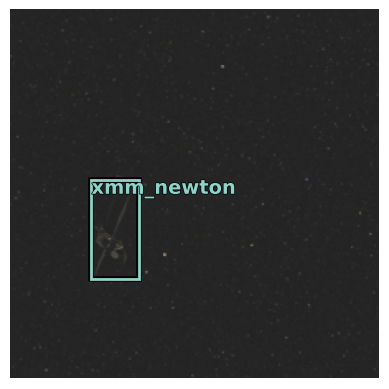

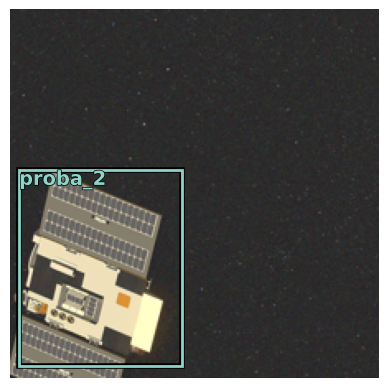

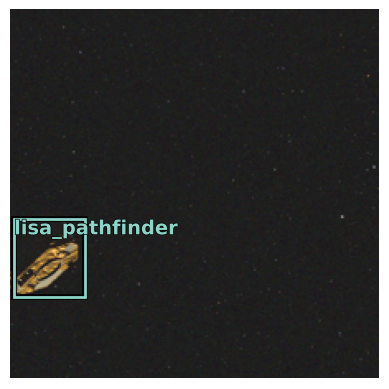

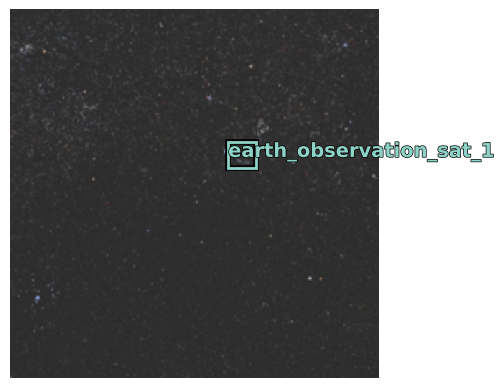

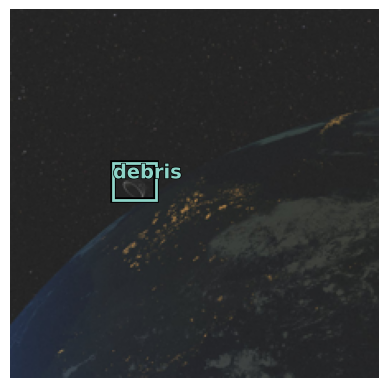

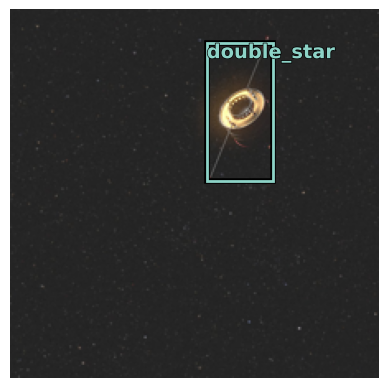

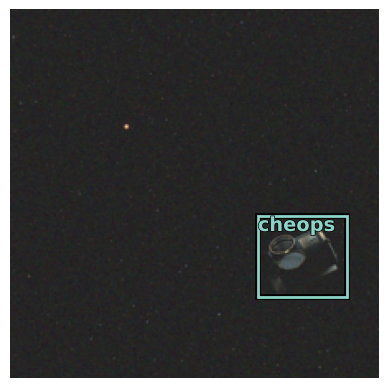

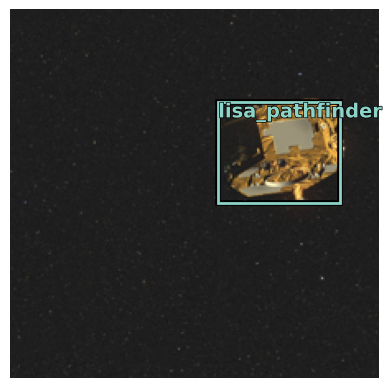

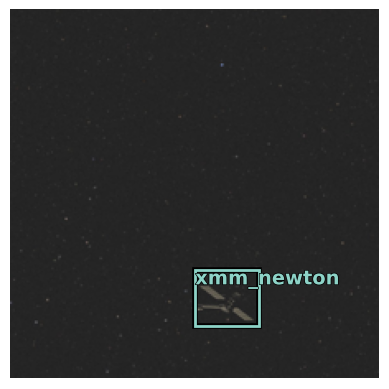

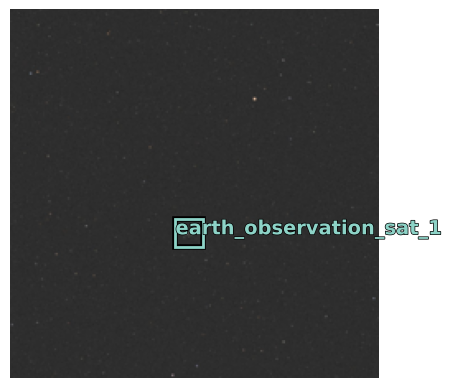

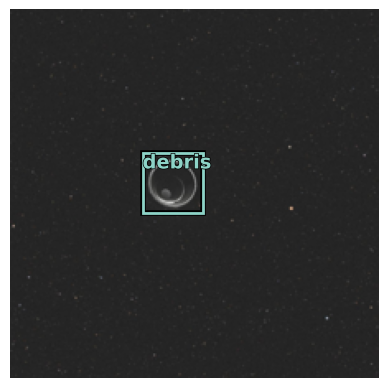

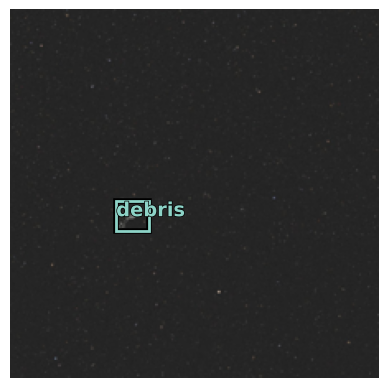

In [96]:
for i in range(1, 22000, 1000):
    img = predimages[i]                     # 'img086351.jpg'
    img_bbox_label = img2bbox_pred[img]     # (array([ 40,  68, 143,  90]), 'smart_1')

    img_scaled = Image.open(data/'test'/img).resize((SIZE, SIZE))

    show_item(img_scaled, img_bbox_label)

# Preparing the submission.csv file

In [97]:
# converting bb_pred_1024 to string
bb_pred_1024_str =['[' + ', '.join(map(str, row)) + ']' for row in bb_pred_1024]
bb_pred_1024_str[:2]

['[265, 822, 337, 919]', '[88, 434, 779, 1012]']

In [98]:
# creating submit dafaframe
dfs = pd.DataFrame({'filename': predimages, 'class': class_pred, 'bbox': bb_pred_1024_str})
dfs.head(5)

filename       class                  bbox
0  img028488.jpg      debris  [265, 822, 337, 919]
1  img011077.jpg      cheops  [88, 434, 779, 1012]
2  img108944.jpg  xmm_newton  [387, 509, 524, 646]
3  img029157.jpg      debris   [792, 74, 912, 195]
4  img010278.jpg      cheops    [31, 14, 765, 601]

In our predictions we have the files listed alphabetically, but we have a `sample_submission.csv` file, where the files are in random order and we are going to reorder our dataframe

In [99]:
# read test file names
dftest = pd.read_csv(data/'labels/sample_submission.csv')
dftest.head(2)

filename  class  bbox
0  img057676.png    NaN   NaN
1  img058116.png    NaN   NaN

In [100]:
#replacing .png with .jpg since we have jpeg files
dftest['filename'] = dftest['filename'].str.replace('.png', '.jpg')
dftest.head(2)

filename  class  bbox
0  img057676.jpg    NaN   NaN
1  img058116.jpg    NaN   NaN

In [101]:
# setting the first column in dfs as index
dfs = dfs.set_index('filename')

# Reordering rows in dfs to match order in dftest
dfs = dfs.loc[dftest['filename']]
dfs.head(2)

class                  bbox
filename                                            
img057676.jpg  lisa_pathfinder  [121, 642, 268, 780]
img058116.jpg  lisa_pathfinder  [330, 753, 462, 918]

It seems that codalab doesn't like that I'm using filename with .jpg extension, (`The filenames of the images in the submission file doesn't match the names in the test dataset.`) so I'm going to change back the filename to .png extension.

In [102]:
#replacing .jpg with .png because codalab accpets only .png
dfs.index = dfs.index.str.replace('.jpg', '.png')
dfs.head(2)

class                  bbox
filename                                            
img057676.png  lisa_pathfinder  [121, 642, 268, 780]
img058116.png  lisa_pathfinder  [330, 753, 462, 918]

In [103]:
# writing out the submission.csv file
dfs.to_csv('submission2.csv.zip')

In [104]:
true_vocab = {
0:'proba_2',
1:'cheops',
2:'debris',
3:'double_star',
4:'earth_observation_sat_1',
5:'lisa_pathfinder',
6:'proba_3_csc',
7:'proba_3_ocs',
8:'smart_1',
9:'soho',
10:'xmm_newton',
11:'xmm_newton',
}

In [105]:
dfs['true_cid'] = dfs.index.to_series().str[3:5].astype(int)
dfs['true_class'] = dfs['true_cid'].map(true_vocab)
dfs.head()

class                  bbox  true_cid  \
filename                                                         
img057676.png  lisa_pathfinder  [121, 642, 268, 780]         5   
img058116.png  lisa_pathfinder  [330, 753, 462, 918]         5   
img056033.png  lisa_pathfinder  [370, 237, 566, 447]         5   
img053764.png  lisa_pathfinder  [563, 448, 734, 648]         5   
img054936.png          proba_2  [707, 673, 963, 879]         5   

                    true_class  
filename                        
img057676.png  lisa_pathfinder  
img058116.png  lisa_pathfinder  
img056033.png  lisa_pathfinder  
img053764.png  lisa_pathfinder  
img054936.png  lisa_pathfinder

In [106]:
test_class_accuracy = (dfs['class']==dfs['true_class']).sum() / len(dfs) * 100
test_class_accuracy

91.75

In [107]:
dfs['class'] = dfs['true_class']
dfs.to_csv('submission2E.csv.zip', columns=['class', 'bbox'])